# Tanzania Waterpumps

Use the Tanzania waterpump dataset to predict if a site is
* Functional
* Needing repairs
* Non-Functional

### Loading the data

In [1]:
# Basic imports for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Create a seed, so that results can be reproduced
np.random.seed(42)

In [3]:
# Define dataframe for training data
import os


data_path = "./data/"
dataframes = dict()

# Walk through all files
for _, _, filenames in os.walk(data_path):
    for name in filenames:
        
        _name = os.path.splitext(name)[0]

        # Put it into a dataframe
        dataframes[_name] = pd.read_csv(data_path + name)

dataframes.keys()

dict_keys(['sample_submission', 'test_features', 'train_features', 'train_labels'])

In [4]:
# Join training data back together
train = pd.concat([
        dataframes['train_features'], 
        dataframes['train_labels'].drop(columns=['id'])
    ], 
    axis=1
)

# Check shape of resulting data
print(train.shape)

(59400, 41)


### Exploratory Data Analysis


#### 1) Descriptive statistics

In [5]:
nulls = list()
# Which columns have null values?
for x in train.isnull().sum().items():
    if x[1] >= 1:
        print(f"Column {x[0]} has {x[1]} null values "\
              f"(%{(x[1]/len(train))*100:.2f}).")
        nulls.append(x[0])
        

Column funder has 3635 null values (%6.12).
Column installer has 3655 null values (%6.15).
Column subvillage has 371 null values (%0.62).
Column public_meeting has 3334 null values (%5.61).
Column scheme_management has 3877 null values (%6.53).
Column scheme_name has 28166 null values (%47.42).
Column permit has 3056 null values (%5.14).


`Null values can be an indicator of no input being applicable, or missing data.`


### Suspected "N/A"
- funder
- installer
- subvillage


### Suspected "Missing"
- public_meeting
- scheme_management
- scheme_name
- permit


In [6]:
zeros = list()
# Which columns have zeros?
for col in train.select_dtypes('number'):
    length = train.shape[0]
    
    # Check that 0 is a value
    if 0 in train[col].unique():
        zero_count = train[col].value_counts()[0]
        
    # If not, set 0 to indicate no zeros
    else:
        zero_count = 0
        
    # Percent of column that is zeros
    zero_ratio = (zero_count / length) * 100
    print(f"Column {col} has {zero_count} zeros (%{zero_ratio:.2f})")
    
    # Add to zeros list if a zero is present
    if zero_ratio > 0:
        zeros.append(col)

Column id has 1 zeros (%0.00)
Column amount_tsh has 41639 zeros (%70.10)
Column gps_height has 20438 zeros (%34.41)
Column longitude has 1812 zeros (%3.05)
Column latitude has 0 zeros (%0.00)
Column num_private has 58643 zeros (%98.73)
Column region_code has 0 zeros (%0.00)
Column district_code has 23 zeros (%0.04)
Column population has 21381 zeros (%35.99)
Column construction_year has 20709 zeros (%34.86)


`Zeros can either be valid input, or placeholders for unknown`

### Suspected "Valid"
- id
- amount_tsh
- num_private

### Suspected "Unknown"
- longitude
- district_code
- construction_year

### Gray Area
- population
- gps_height

In [7]:
# Do any of the zeros columns have null values?
{x : "yes" if x in nulls else "no" for x in zeros}


{'id': 'no',
 'amount_tsh': 'no',
 'gps_height': 'no',
 'longitude': 'no',
 'num_private': 'no',
 'district_code': 'no',
 'population': 'no',
 'construction_year': 'no'}

In [8]:
# Do any columns have all same / different values?
all_same = list()
all_different = list()

for col in train:
    
    # If all values are the same
    if train[col].nunique() == 1:
        print(f"Column {col} has no variance.")
        all_same.append(col)
        
    # If all values are different
    if train[col].nunique() == len(train[col]):
        print(f"Column {col} has 100% variance.")
        all_different.append(col)


Column id has 100% variance.
Column recorded_by has no variance.


`Variance in columns tells us how much information is stored there.`

In both cases, 100% and 0% variance are effectively useless. We'll drop these columns.

In [9]:
# Check for duplicate (or very similar) columns
categorical = train.select_dtypes('object')

# Create hash table of unique values and a list for tracked keys
uniques = dict()
tracked = set()

for column in categorical.columns:
    uniques[column] = list(categorical[column].unique())
    
# Check current key values against all other keys' values
for key in uniques.keys():
    # add current key to tracked set
    tracked.add(key)
    # set starting values
    starting_values = set(uniques[key])
    sv_length = len(starting_values)
    for key2 in uniques.keys():
        # If key is tracked, do nothing.
        if key2 not in tracked:
            # set comparison values
            compare_values = set(uniques[key2])
            cv_length = len(compare_values)
            # Calculate similarity
            shared = len(starting_values.intersection(compare_values))
            difference = len(compare_values.difference(starting_values))
            shared_pct = (shared / sv_length) if shared > 0 else None
            diff_pct = (difference / cv_length) if difference > 0 else None
            
            # Print statements
            if shared_pct and shared_pct >= 0.2:
                print(f"{key} / {key2} shared: {shared_pct*100:.2f}%" )
                
                if diff_pct:
                    print(f"{key} / {key2} difference: {diff_pct*100:.2f}%.")

                print('\n')

funder / installer shared: 25.76%
funder / installer difference: 77.21%.


basin / subvillage shared: 22.22%
basin / subvillage difference: 99.99%.


basin / lga shared: 22.22%
basin / lga difference: 98.40%.


lga / ward shared: 27.20%
lga / ward difference: 98.37%.


public_meeting / scheme_management shared: 33.33%
public_meeting / scheme_management difference: 92.31%.


public_meeting / scheme_name shared: 33.33%
public_meeting / scheme_name difference: 99.96%.


public_meeting / permit shared: 100.00%


extraction_type / extraction_type_group shared: 50.00%
extraction_type / extraction_type_group difference: 30.77%.


extraction_type_group / extraction_type_class shared: 38.46%
extraction_type_group / extraction_type_class difference: 28.57%.


management / management_group shared: 25.00%
management / management_group difference: 40.00%.


management_group / payment shared: 40.00%
management_group / payment difference: 71.43%.


management_group / payment_type shared: 40.00%
manag

### Visualizing

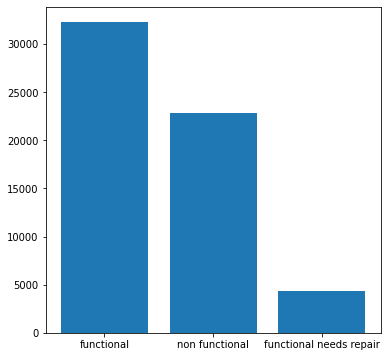

In [10]:
status = train['status_group'].value_counts()

fig, ((ax1)) = plt.subplots(1,1, figsize=(6,6))
ax1.bar(status.index, 
        status.values)
plt.show()


Observation: Our classes are _inbalanced_ and will require stratification as well as class weight balancing for our model.

In [11]:
# Split into functional / non-functional (majority classes)
functional = train[train['status_group']=='functional']
non_functional = train[train['status_group']=='non functional']

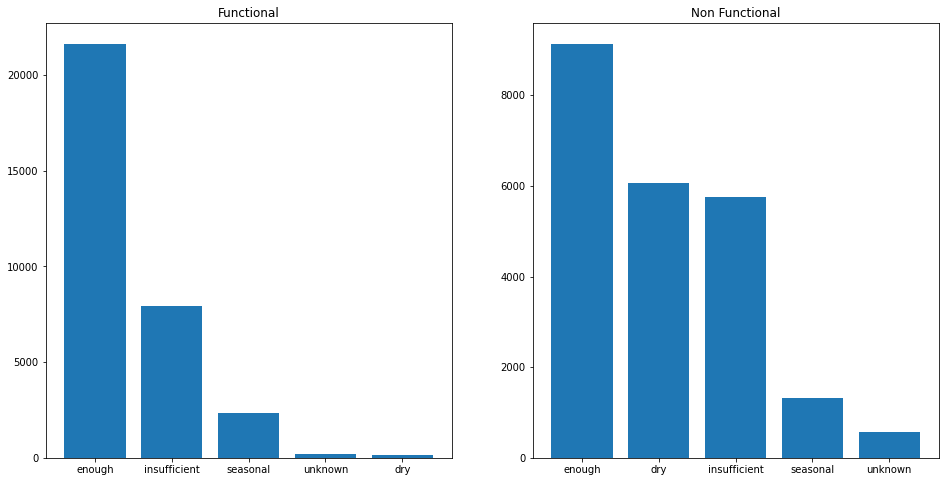

In [12]:
# Visualize difference in quantity over different functionality states
func = functional['quantity'].value_counts()
non_func = non_functional['quantity'].value_counts()

fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(16,8))
ax1.bar(func.index,
        func.values)
ax1.set_title('Functional')

ax2.bar(non_func.index,
        non_func.values)
ax2.set_title('Non Functional')

plt.show()

Observation: Quantity is a fair marker for functionality, but not the only cause of variance.

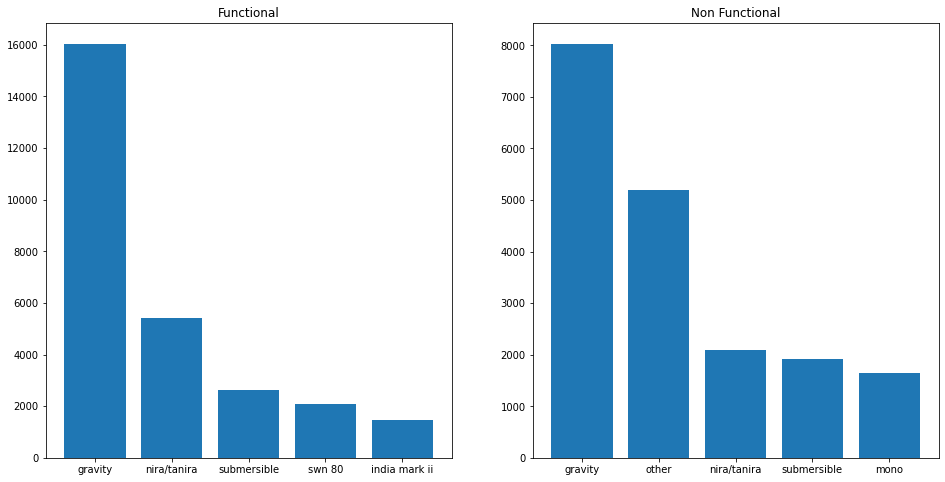

In [13]:
# Visualize difference in extraction_type over target
func = functional['extraction_type'].value_counts()[:5]
non_func = non_functional['extraction_type'].value_counts()[:5]

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(16,8))

ax1.bar(func.index, 
        func.values)
ax1.set_title('Functional')

ax2.bar(non_func.index, 
        non_func.values)
ax2.set_title('Non Functional')

plt.show()

Observation: Very little variance explained with extraction type.

And here I've created a map of Tanzania, showcasing essentially nothing.

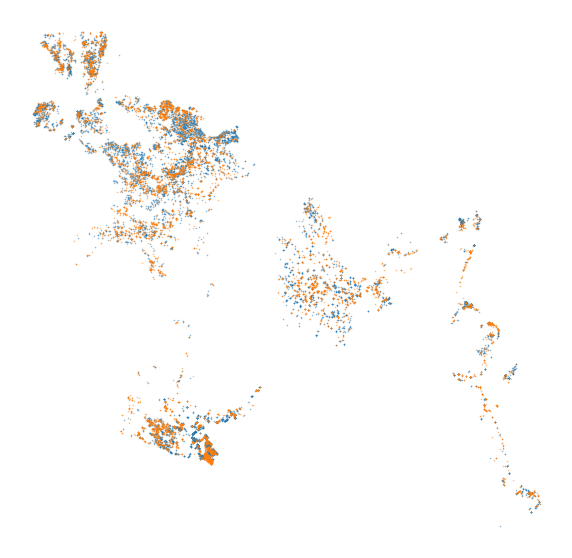

In [14]:
gps_f = functional[(functional['gps_height'] < 1) & (functional['longitude'] > 1)]
gps_nf = non_functional[(non_functional['gps_height'] < 1) & (non_functional['longitude'] > 1)]

fig, ((ax1)) = plt.subplots(1,1, figsize=(10,10))

ax1.scatter(gps_f['longitude'], 
            gps_f['latitude'], 
            alpha=.5, 
            s=.3)
ax1.scatter(gps_nf['longitude'], 
            gps_nf['latitude'], 
            alpha=.5, 
            s=.3)

ax1.axis('off')
plt.show()

Placement for `0 gps` doesn't appear random. Reasonable to say this is a legitmate value.

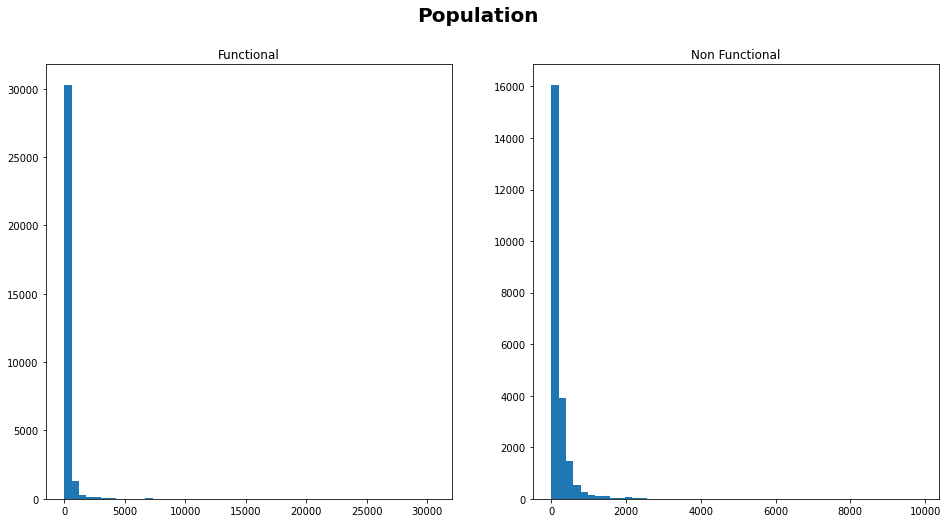

In [15]:
# Check the distribution of population averages over functionality
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(functional['population'], bins=50)
ax2.hist(non_functional['population'], bins=50)
ax1.set_title('Functional')
ax2.set_title('Non Functional')
plt.suptitle(t='Population', fontsize=20, fontweight='bold')
plt.show()

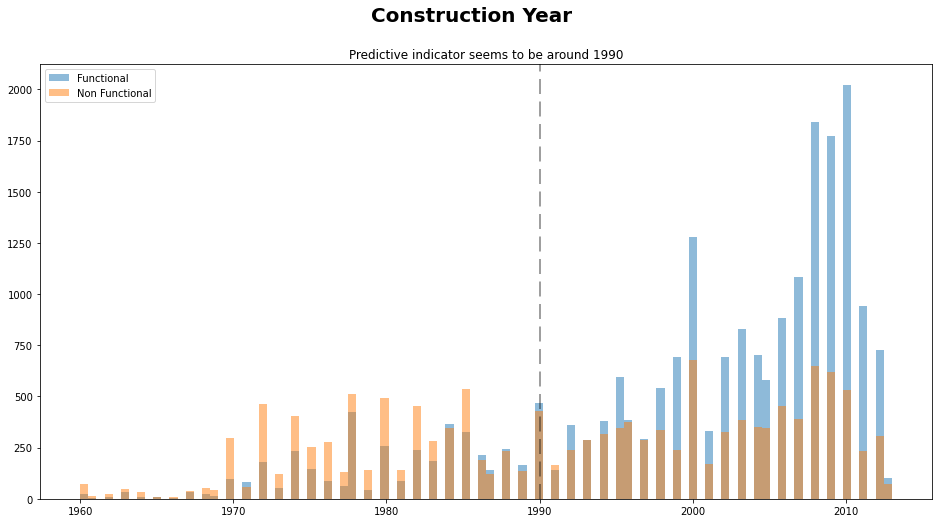

In [16]:
# How about construction year?
fig, ((ax1)) = plt.subplots(1,1, figsize=(16,8))

ax1.hist(functional[functional['construction_year']>1]\
         ['construction_year'], 
         bins=100,
         alpha=0.5,
         label=["Functional"])

ax1.hist(non_functional[non_functional['construction_year']>1]\
         ['construction_year'], 
         bins=100, 
         alpha=0.5, 
         label=["Non Functional"])

ax1.axvline(1990, 
            color='black', 
            alpha=0.5, 
            dashes=(10,5))

ax1.set_title('Predictive indicator seems to be around 1990')
plt.legend()
plt.suptitle(t='Construction Year', fontsize=20, fontweight='bold')
plt.show()

This shows that sites constructed in earlier years do appear to be predictive of being non-functional. This fits with the intuition that older sites will be more prone to failing. Interestingly, most of the sites constructed in the latest date also appear to be non-functioning. 

### Data Wrangling

In [17]:
# Create a function to wrangle the data
def clean_data(df):
    """ Clean the data for presentation to a model
        
        Inputs: 
            
            df: pandas.DataFrame object containing only the X feature matrix
            
        Outputs:
            
            df: pandas.DataFrame object containing the cleaned X
            feature matrix
        
        Note: Function may not work as intended if the y target vector(s) are
        supplied. Ensure to do Feature split before applying this function.
    """
    # Create new object in memory
    df = df.copy()
    
    
    # =================== #
    #   Impute Lat/Lon    # ------------------------------------------------ #
    # =================== #
    
    # Conditions for longitude
    g_lon = df['longitude'] > 1 # Known
    b_lon = df['longitude'] < 1 # Unknown
    # Conditions for latitude
    g_lat = df['latitude'] < -1 # Known
    b_lat = df['latitude'] > -1 # Unknown
    
    # Find means for known lat/lon
    lon_means = dict(df.loc[g_lon,:].groupby('region')['longitude'].mean())
    lat_means = dict(df.loc[g_lat,:].groupby('region')['latitude'].mean())
    
    # Impute mean of known region longitude for unknown value
    for key in lon_means:
        condition = df['region'] == key
        df.loc[(condition) & (b_lon), 'longitude'] = lon_means[key]
        
    #Imput mean of known region latitude for unknown value
    for key in lat_means:
        condition = df['region'] == key
        df.loc[(condition) & (b_lat), 'latitude'] = lat_means[key]
    
    # =================== #
    #  Construction Year  # ------------------------------------------------ #
    # =================== #
    
    # Onehot 0 values in construction year
    df.loc[:,'year_unknown'] = [1 if x < 1 else 0 \
                              for x in df['construction_year']]
    # Onehot pre-1990
    df.loc[:,'pre_1990'] = [1 if x < 1990 and x > 1 else 0 \
                            for x in df['construction_year']]
    # Onehot post-1990
    df.loc[:,'post_1990'] = [1 if x >= 1990 else 0 \
                             for x in df['construction_year']]
    
    # =================== #
    #     Cardinality     # ------------------------------------------------ #
    # =================== #
    
    # Loop through each column of the dataframe
    for column in df.select_dtypes(exclude='number'):
        
        # Mark NaNs
        df.loc[df[column].isin([np.nan]), column] = "unknown"
        # If more than 25 Possible values
        if df[column].nunique() > 25:
            # Keep the top 25
            top = df[column].value_counts()[:25].index
            df.loc[~df[column].isin(top), column] = "other"
            
    return df


In [18]:
# Import model libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split


In [19]:
# Split feature from target in the training data
to_drop = ['status_group','quantity_group', 'payment_type', 
           'source_type', 'waterpoint_type_group', 'extraction_type_group', 
           'id', 'lga', 'recorded_by']
features = train.drop(columns=to_drop).columns
target = 'status_group'

# Create X feature matrix and y target vector
X = train[features]
y = train[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  random_state=42, 
                                                  test_size=0.2, 
                                                  stratify=y)


In [20]:
# Clean training and validation feature matricies
X_train = clean_data(X_train)
X_val = clean_data(X_val)


In [21]:
X_train = X_train.drop(columns=['construction_year', 'region'])
X_val = X_val.drop(columns=['construction_year', 'region'])

In [22]:
# Create a Pipeline
pipeline = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_estimators=128,
        max_features=0.3,
        class_weight='balanced_subsample',
        max_samples=0.58
    )
)

# Score the pipeline
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)


0.80993265993266

In [23]:
# Get predictions for validation set
y_pred = pipeline.predict(X_val)

In [24]:
# Print Classification Report
print(classification_report(y_pred, y_val))

                         precision    recall  f1-score   support

             functional       0.90      0.80      0.85      7249
functional needs repair       0.30      0.58      0.40       450
         non functional       0.78      0.85      0.81      4181

               accuracy                           0.81     11880
              macro avg       0.66      0.74      0.69     11880
           weighted avg       0.83      0.81      0.82     11880



This model does not do a very good job at predicting if a waterpump is functional but needing repairs.

### ROC/AUC

How well does the model distinguish the different possible classes?

In [25]:
from sklearn.metrics import roc_auc_score


# Calculate roc/auc
y_pred_proba = pipeline.predict_proba(X_val)
roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted')


0.909754481434697

This means that approximately 91% of the area is under my ROC curve.

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


# Define the classes for this problem
class_names = ['functional', 'non functional', 'functional needs repair']

# Binarize classes (0/1 for each class)
y_train_b = label_binarize(y_train, classes=class_names)
y_val_b = label_binarize(y_val, classes=class_names)

n_classes = 3

# Instantiate OVR method
ovr_clf = OneVsRestClassifier(pipeline)
y_score = ovr_clf.fit(X_train, y_train_b).predict_proba(X_val)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_b[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


d:\virtual-envs\main\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
d:\virtual-envs\main\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
d:\virtual-envs\main\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


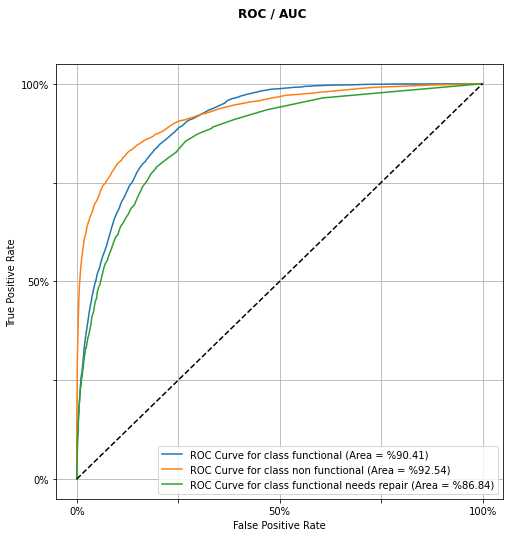

In [27]:
# plot the roc curves
fig, ((ax1)) = plt.subplots(1,1, figsize=(8,8))
for i in range(n_classes):
    ax1.plot(fpr[i], 
             tpr[i], 
             label=f"ROC Curve for class {class_names[i]}" \
                   f" (Area = %{roc_auc[i]*100:.2f})")
ax1.plot([0,1],[0,1], '--', color='black')
ax1.set_xticks([0,0.25,0.5,0.75,1])
ax1.set_xticklabels(['0%', '', '50%','',  '100%'])
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0%', '', '50%', '', '100%'])
ax1.grid(True)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
fig.set_facecolor('white')
fig.suptitle('ROC / AUC', fontweight='bold')
plt.legend()
plt.show()
